In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap --user

In [3]:
from BRScraper import nba
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import shap
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Normalizer, RobustScaler, MaxAbsScaler, MinMaxScaler
from pandas.plotting import scatter_matrix
shap.initjs()

In [4]:
seasons_df = pd.read_csv('Seasons_Stats.csv', index_col = 0)

In [5]:
from selenium import webdriver

Service = webdriver.ChromeService(executable_path="C:\Program Files (x86)\chromedriver.exe")
web_driver = webdriver.Chrome(service = Service)
web_driver.get("https://hoopshype.com/salaries/players/2017-2018/")

# Now, let's get the list of elements again (assuming it selects multiple elements after clicking)
players = web_driver.find_elements('xpath', '//td[@class="name"]')

many_players = []
for player in players:
    # Assuming you want to append the text of each element to many_players
    many_players.append(player.text)
salaries = web_driver.find_elements('xpath','//td[@class ="hh-salaries-sorted"]')
salary_list= []
for s in range(len(salaries)):
    salary_list.append(salaries[s].text)
data_tuple = list(zip(many_players[1:],salary_list[1:])) #players and salaries paired together
salary_df = pd.DataFrame(data_tuple, columns = ['Player_Name','Salary'])


In [6]:
salary_df['Salary'] = salary_df['Salary'].replace({'\$': '', ',': ''}, regex=True).astype('float').astype('Int64')
def convert_dtypes(df):
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = df[col].astype(np.int64)
        elif pd.api.types.is_float_dtype(df[col]) or df[col].dtype == 'Float64':
            df[col] = df[col].astype(np.float64)
        elif df[col].dtype == 'Int64':
            df[col] = df[col].astype(np.int64)
        elif pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].astype(str)
    return df
salary_df = convert_dtypes(salary_df)
salary_df['Salary'] = salary_df["Salary"]/1000000

In [7]:
salary_df

,Player_Name,Salary
0,Stephen Curry,34.682550
1,LeBron James,33.285709
2,Paul Millsap,30.769231
3,Gordon Hayward,29.727900
4,Blake Griffin,29.512900
...,...,...
581,Andre Ingram,0.046079
582,Trey McKinney-Jones,0.046079
583,Aaron Jackson,0.046079
584,Jameel Warney,0.046079


# Feature Engineering

In [8]:
salary_df = salary_df.rename(columns = {'Player_Name':'Player'})
salary_df

,Player,Salary
0,Stephen Curry,34.682550
1,LeBron James,33.285709
2,Paul Millsap,30.769231
3,Gordon Hayward,29.727900
4,Blake Griffin,29.512900
...,...,...
581,Andre Ingram,0.046079
582,Trey McKinney-Jones,0.046079
583,Aaron Jackson,0.046079
584,Jameel Warney,0.046079


In [9]:
seasons_df.describe()

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24624.000000,24616.000000,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,20792.000000,...,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
mean,1992.594989,26.664405,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,6.181565,...,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,17.429594,3.841892,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,4.872685,...,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,1950.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1981.000000,24.000000,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,2.600000,...,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,1996.000000,26.000000,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,5.400000,...,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000
75%,2007.000000,29.000000,75.000000,45.000000,1971.000000,15.600000,0.544000,0.288000,0.400000,9.000000,...,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000
max,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000000,6.000000,100.000000,...,1.000000,587.000000,1111.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000


In [10]:
seasons_df = seasons_df[seasons_df['Year']>=2017]

In [11]:
stats_df = seasons_df[['Year','Pos','Age','Player','G','PER','MP','PTS','AST','TRB','TOV','BLK','STL']]

In [12]:
stats_df.drop_duplicates(subset = ['Player'],keep = 'first')

,Year,Pos,Age,Player,G,PER,MP,PTS,AST,TRB,TOV,BLK,STL
24096,2017.0,SG,23.0,Alex Abrines,68.0,10.1,1055.0,406.0,40.0,86.0,33.0,8.0,37.0
24097,2017.0,PF,26.0,Quincy Acy,38.0,11.8,558.0,222.0,18.0,115.0,21.0,15.0,14.0
24100,2017.0,C,23.0,Steven Adams,80.0,16.5,2389.0,905.0,86.0,615.0,146.0,78.0,88.0
24101,2017.0,SG,31.0,Arron Afflalo,61.0,9.0,1580.0,515.0,78.0,125.0,42.0,7.0,21.0
24102,2017.0,C,28.0,Alexis Ajinca,39.0,12.9,584.0,207.0,12.0,177.0,31.0,22.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,PF,24.0,Cody Zeller,62.0,16.7,1725.0,639.0,99.0,405.0,65.0,58.0,62.0
24687,2017.0,C,27.0,Tyler Zeller,51.0,13.0,525.0,178.0,42.0,124.0,20.0,21.0,7.0
24688,2017.0,C,20.0,Stephen Zimmerman,19.0,7.3,108.0,23.0,4.0,35.0,3.0,5.0,2.0
24689,2017.0,SF,22.0,Paul Zipser,44.0,6.9,843.0,240.0,36.0,125.0,40.0,16.0,15.0


In [13]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 24096 to 24690
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    595 non-null    float64
 1   Pos     595 non-null    object 
 2   Age     595 non-null    float64
 3   Player  595 non-null    object 
 4   G       595 non-null    float64
 5   PER     595 non-null    float64
 6   MP      595 non-null    float64
 7   PTS     595 non-null    float64
 8   AST     595 non-null    float64
 9   TRB     595 non-null    float64
 10  TOV     595 non-null    float64
 11  BLK     595 non-null    float64
 12  STL     595 non-null    float64
dtypes: float64(11), object(2)
memory usage: 65.1+ KB


In [14]:
pd.options.mode.copy_on_write = True
a = ['MPG','PPG','APG','RPG','TOPG','BPG','SPG']
b = ['MP','PTS','AST','TRB','TOV','BLK','STL']
for i,j in zip(a,b):
    stats_df[i] = stats_df[j]/stats_df['G']
stats_df = stats_df.drop(b,axis = 1)

In [15]:
stats_df['Pos'].value_counts()

SG      125
SF      121
PF      119
PG      116
C       113
PF-C      1
Name: Pos, dtype: int64

In [16]:
stats_df.loc[stats_df['Pos'] == 'PF-C','Pos'] = 'PF'

In [17]:
stats_df['Pos'].value_counts()

SG    125
SF    121
PF    120
PG    116
C     113
Name: Pos, dtype: int64

In [18]:
nba_df= pd.merge(stats_df,salary_df)

In [19]:
nba_df = nba_df.drop_duplicates(subset = ['Player'],keep = 'first')
nba_df

,Year,Pos,Age,Player,G,PER,MPG,PPG,APG,RPG,TOPG,BPG,SPG,Salary
0,2017.0,SG,23.0,Alex Abrines,68.0,10.1,15.514706,5.970588,0.588235,1.264706,0.485294,0.117647,0.544118,5.725000
1,2017.0,PF,26.0,Quincy Acy,38.0,11.8,14.684211,5.842105,0.473684,3.026316,0.552632,0.394737,0.368421,1.709538
4,2017.0,C,23.0,Steven Adams,80.0,16.5,29.862500,11.312500,1.075000,7.687500,1.825000,0.975000,1.100000,22.471911
5,2017.0,SG,31.0,Arron Afflalo,61.0,9.0,25.901639,8.442623,1.278689,2.049180,0.688525,0.114754,0.344262,5.328652
6,2017.0,C,28.0,Alexis Ajinca,39.0,12.9,14.974359,5.307692,0.307692,4.538462,0.794872,0.564103,0.512821,4.961798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,2017.0,PF,28.0,Thaddeus Young,74.0,14.9,30.229730,11.000000,1.648649,6.067568,1.297297,0.405405,1.540541,12.921348
473,2017.0,PF,24.0,Cody Zeller,62.0,16.7,27.822581,10.306452,1.596774,6.532258,1.048387,0.935484,1.000000,12.584270
474,2017.0,C,27.0,Tyler Zeller,51.0,13.0,10.294118,3.490196,0.823529,2.431373,0.392157,0.411765,0.137255,1.709538
475,2017.0,SF,22.0,Paul Zipser,44.0,6.9,19.159091,5.454545,0.818182,2.840909,0.909091,0.363636,0.340909,1.312611


In [20]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 476
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    388 non-null    float64
 1   Pos     388 non-null    object 
 2   Age     388 non-null    float64
 3   Player  388 non-null    object 
 4   G       388 non-null    float64
 5   PER     388 non-null    float64
 6   MPG     388 non-null    float64
 7   PPG     388 non-null    float64
 8   APG     388 non-null    float64
 9   RPG     388 non-null    float64
 10  TOPG    388 non-null    float64
 11  BPG     388 non-null    float64
 12  SPG     388 non-null    float64
 13  Salary  388 non-null    float64
dtypes: float64(12), object(2)
memory usage: 45.5+ KB


# Train Test Split

In [23]:
y = nba_df['Salary']
X = nba_df.drop(['Salary','Player','Pos'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

# Preprocessor

In [24]:
def my_preprocessor(num_cols,cat_cols):
    numerical_transformer = SimpleImputer(strategy ='constant')
    categorical_transformer = Pipeline(steps = [('Imputer',SimpleImputer(strategy = 'most_frequent')),
                                                ('Onehot', OneHotEncoder(handle_unknown = 'ignore'))])
    preprocessor = ColumnTransformer(transformers = [('num',numerical_transformer,num_cols),
                                                     ('cat', categorical_transformer,cat_cols)])
    return preprocessor

cat_cols = [var for var in X_train.columns if X_train[var].nunique()<10 and X_train[var].dtype == 'object']
num_cols = [var for var in X_train.columns if X_train[var].dtype in ['float64', 'Int64']]
total_cols = cat_cols +num_cols
preprocessor = my_preprocessor(num_cols, cat_cols)

#Transformed
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test) #!!!! This is the issue (fixed it!!)
feature_names = X_train.columns
X_train_trans_df = pd.DataFrame(X_train_trans, columns=feature_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

# Functions

In [25]:
def score(pred):
    return print('MAE:', mean_absolute_error(y_test,pred))

#cross validation check
def cross_val(pipe):
    scores = -1 * cross_val_score(pipe,X,y,cv=5, scoring = 'neg_mean_absolute_error')
    print(scores)
    print('Cross validation score: ',scores.mean())
def beeswarm(model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)    
    return np.shape(shap_values.values)
def RegEval(model, y_test,X_test,nameindex,yname,totaldt, predict = True):
    ypred = model.predict(X_test)
    X_test_trans_df['Pred_y'] = ypred
    dt = pd.merge(nba_df,X_test_trans_df,how = 'right')
    X_test_trans_df.drop('Pred_y',axis=1,inplace = True)
    dt = dt[[nameindex,yname,'Pred_y']]
    dt.sort_values(by = yname, ascending = False,inplace = True)
    rmse = np.sqrt(mean_squared_error(y_test,ypred))
    r2 = r2_score(y_test,ypred)
    print('RMSE: ', rmse)
    print('r2 score: ',r2)
    if predict:
        return dt.head(10)


# Decision Tree

In [26]:
dec_tree = DecisionTreeRegressor(random_state =42)
dec_tree.fit(X_train_trans,y_train)
dec_pred = dec_tree.predict(X_test_trans)
score(dec_pred)

MAE: 4.261278555555555


In [27]:
# MAE: 4.261278555555555

In [28]:
RegEval(dec_tree,y_test,X_test_trans,'Player','Salary',nba_df)

RMSE:  6.103998571498472
r2 score:  0.36394014167166744


,Player,Salary,Pred_y
9,Blake Griffin,29.512900,22.642350
88,Kyle Lowry,28.903704,18.868626
101,Russell Westbrook,28.299399,28.299399
104,Al Horford,27.734405,21.461010
83,Damian Lillard,26.153057,27.739975
12,Kevin Durant,25.000000,22.642350
29,Otto Porter,24.773250,25.686667
52,Harrison Barnes,23.112004,17.000000
36,Nicolas Batum,22.434783,14.100000
77,Greg Monroe,21.384175,13.618750


In [29]:
# RMSE:  6.103998571498472
# r2 score:  0.36394014167166744

# Random Forest

In [30]:
rand_forest = RandomForestRegressor(random_state = 42)
rand_forest.fit(X_train,y_train)
pred_rand = rand_forest.predict(X_test)
score(pred_rand)

MAE: 3.2734392788034183


In [31]:
# MAE: 3.2734392788034183

In [32]:
RegEval(rand_forest,y_test,X_test,'Player','Salary',nba_df)

RMSE:  4.394455715153206
r2 score:  0.6703300774667338


,Player,Salary,Pred_y
9,Blake Griffin,29.512900,24.239064
88,Kyle Lowry,28.903704,26.316622
101,Russell Westbrook,28.299399,27.579347
104,Al Horford,27.734405,19.611464
83,Damian Lillard,26.153057,23.713205
12,Kevin Durant,25.000000,23.845135
29,Otto Porter,24.773250,17.106755
52,Harrison Barnes,23.112004,16.708126
36,Nicolas Batum,22.434783,15.908956
77,Greg Monroe,21.384175,11.236014


In [33]:

# RMSE:  4.394455715153206
# r2 score:  0.6703300774667338

# XGBoost

In [34]:
XGboost = XGBRegressor(random_state =42)
XGboost.fit(X_train,y_train)
xgb_pred = XGboost.predict(X_test)
score(xgb_pred)

MAE: 3.677003678315105


In [35]:
# MAE: 3.677003678315105

In [36]:
RegEval(XGboost,y_test,X_test,'Player','Salary',nba_df)

RMSE:  4.904639055310156
r2 score:  0.5893392030000122


,Player,Salary,Pred_y
9,Blake Griffin,29.512900,23.910782
88,Kyle Lowry,28.903704,23.073488
101,Russell Westbrook,28.299399,31.734169
104,Al Horford,27.734405,21.306831
83,Damian Lillard,26.153057,25.346809
12,Kevin Durant,25.000000,23.229963
29,Otto Porter,24.773250,19.007746
52,Harrison Barnes,23.112004,13.866962
36,Nicolas Batum,22.434783,16.917240
77,Greg Monroe,21.384175,11.737572


In [37]:
# RMSE:  4.904639055310156
# r2 score:  0.5893392030000122


# AdaBoost

In [38]:
Adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 5),n_estimators = 250,random_state =42)
Adaboost.fit(X_train,y_train)
adaboost_pred = Adaboost.predict(X_test)
score(adaboost_pred)

MAE: 3.5640521266694605


In [39]:
# MAE: 3.5640521266694605

In [40]:
RegEval(Adaboost,y_test,X_test,'Player','Salary',nba_df)

RMSE:  4.729227492787578
r2 score:  0.6181880184004143


,Player,Salary,Pred_y
9,Blake Griffin,29.512900,24.897169
88,Kyle Lowry,28.903704,27.465196
101,Russell Westbrook,28.299399,28.299399
104,Al Horford,27.734405,17.324529
83,Damian Lillard,26.153057,24.150843
12,Kevin Durant,25.000000,24.022233
29,Otto Porter,24.773250,10.295451
52,Harrison Barnes,23.112004,17.745894
36,Nicolas Batum,22.434783,15.026153
77,Greg Monroe,21.384175,10.849525


In [41]:
# RMSE:  4.729227492787578
# r2 score:  0.6181880184004143

# Beeswarm Plots

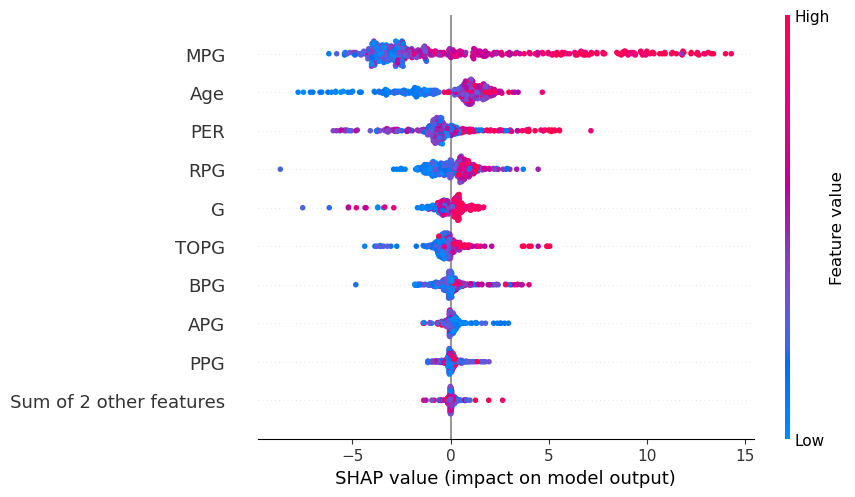

(388, 11)

In [42]:
beeswarm(dec_tree)

In [ ]:
beeswarm(XGboost)

In [ ]:
beeswarm(rand_forest)